## Predicting Sale Price of Bulldozers using ML

#### 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

#### 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

#### 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

- อ่าน RMSLE เพิ่มเติม https://datarockie.com/blog/top-ten-machine-learning-metrics/#:~:text=RMSE%20%E0%B8%A2%E0%B9%88%E0%B8%AD%E0%B8%A1%E0%B8%B2%E0%B8%88%E0%B8%B2%E0%B8%81%20%E2%80%9CRoot,%E0%B8%A3%E0%B8%B9%E0%B8%97%E0%B8%81%E0%B8%A5%E0%B8%B1%E0%B8%9A%E0%B9%84%E0%B8%94%E0%B9%89%E0%B9%84%E0%B8%AB%E0%B8%A1)

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

#### 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

## EDA

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [72]:
# Importing training and validation sets
dtf = pd.read_csv("../resources/bluebook-for-bulldozers/TrainAndValid.csv",
                  low_memory=False)

In [73]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [74]:
dtf.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

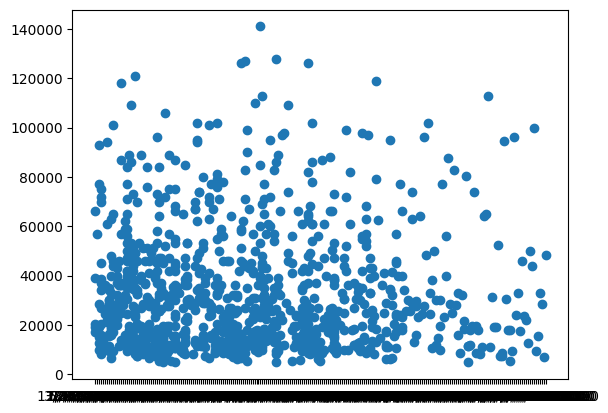

In [75]:
fig, ax = plt.subplots()
ax.scatter(dtf["saledate"][:1000], dtf["SalePrice"][:1000])

<Axes: ylabel='Frequency'>

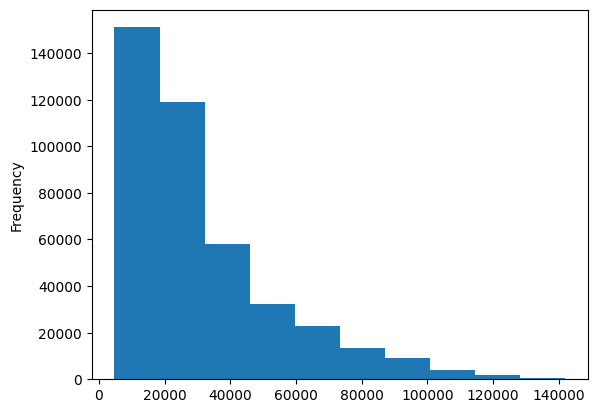

In [76]:
dtf.SalePrice.plot.hist()

In [77]:
dtf.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

### Parsing dates
According to dtf.saledate[:1000], the result are shown as time object. We need to use parse date

- https://www.hitexts.com/data/data-cleaning/
- https://pandas.pydata.org/docs/user_guide/timeseries.html
- การจัดการกับข้อมูลที่เป็นวันที่ (Parsing Dates)
วันเดือนปีและเวลา ที่มาในตารางหรือชุดข้อมูลบางครั้งก็มีรูปแบบที่ไม่ตรงกันหรือประเภทของข้อมูลไม่ใช่ datetime ดังนั้นข้อมูลวันที่เหล่านี้จึงควรจัดให้อยู่ในรูปแบบการเขียนเดียวกัน และมีประเภทเป็นdatetime จริง ๆ
- when we work with time series data, need to enrich the time and date components as much as possible. We can do that by telling pandas which of our columns has dates in it using the 'parse_dates' parameter.

In [78]:
# Import data again but this time parse dates
dtf_parsd = pd.read_csv("../resources/bluebook-for-bulldozers/TrainAndValid.csv",
                        low_memory=False,
                        parse_dates=["saledate"])
# Check parameter type
dtf_parsd.saledate.dtype

dtype('<M8[ns]')

datetime64[ns] is a general dtype, while <M8[ns] is a specific dtype. General dtypes map to specific dtypes

In [79]:
dtf_parsd.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

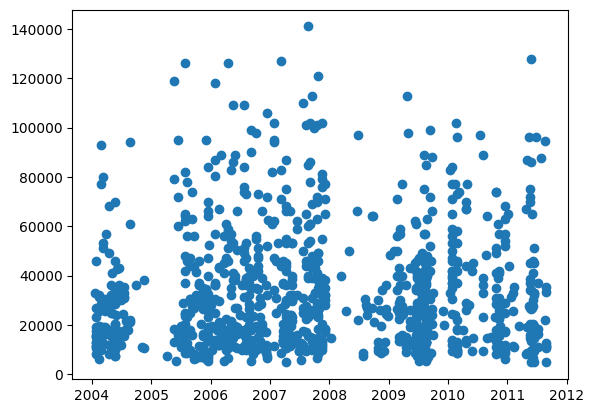

In [80]:
fig, ax = plt.subplots()
ax.scatter(dtf_parsd["saledate"][:1000], dtf_parsd["SalePrice"][:1000])

In [81]:
dtf_parsd.head(10).T

,0,1,2,3,4,5,6,7,8,9
SalesID,1139246,1139248,1139249,1139251,1139253,1139255,1139256,1139261,1139272,1139275
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0,26500.0,21000.0,27000.0,21500.0,65000.0
MachineID,999089,117657,434808,1026470,1057373,1001274,772701,902002,1036251,1016474
ModelID,3157,77,7009,332,17311,4605,1937,3539,36003,3883
datasource,121,121,121,121,121,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007,2004,1993,2001,2008,1000
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0,508.0,11540.0,4883.0,302.0,20700.0
UsageBand,Low,Low,High,High,Medium,Low,High,High,Low,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00,2008-12-18 00:00:00,2004-08-26 00:00:00,2005-11-17 00:00:00,2009-08-27 00:00:00,2007-08-09 00:00:00


### Sorting DataFrame by saledate

In [82]:
# Sort DataFrame in date order
dtf_parsd.sort_values(by=["saledate"], inplace=True, ascending=True)
dtf_parsd.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame
Backup the dataframe when we gone wrong

In [83]:
# Make a copy of the original dataframe
dtf_copy = dtf_parsd.copy()

### Add datetime parameters for saledate column
- https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

In [84]:
# Adding new column for replace saledate column
dtf_copy["saleYear"] = dtf_copy.saledate.dt.year
dtf_copy["saleMonth"] = dtf_copy.saledate.dt.month
dtf_copy["saleDate"] = dtf_copy.saledate.dt.day
dtf_copy["saleDayofweek"] = dtf_copy.saledate.dt.dayofweek
dtf_copy["saleDayofyear"] = dtf_copy.saledate.dt.dayofyear

# Drop original saledate
dtf_copy.drop("saledate", axis=1, inplace=True)
dtf_copy

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDate,saleDayofweek,saleDayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,D38E,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2064,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,337G,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,12G,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119


## Modelling -> RandomForestRegressor

### Try Model -> error: could not convert string to float

* n_jobs : int, default=None
The number of jobs to run in parallel. fit, predict, decision_path and apply are all parallelized over the trees. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
* random_state : int, RandomState instance or None, default=None
Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).


In [85]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
from sklearn.ensemble import RandomForestRegressor

# we can use np.random.seed(42), but rn we will use random_state = 42
model = RandomForestRegressor(n_jobs=-1, random_state=42)
X = dtf_copy.drop("SalePrice", axis=1)
y = dtf_copy.SalePrice

# Fit model
model.fit(X, y)

ValueError: could not convert string to float: 'Low'

ValueError: could not convert string to float: 'Low'-> Turning data to num / Fill missing

### Convert string to categories

[pandas types API](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality) which allows us to interact and manipulate the types of data.
                   

In [86]:
# If you're wondering what df.items() does, let's use a dictionary as an example
random_dict = {"key1": "hello",
               "key2": "world!"}

for key, value in random_dict.items():
    print(f"This is a key: {key}")
    print(f"This is a value: {value}")

This is a key: key1
This is a value: hello
This is a key: key2
This is a value: world!


In [87]:
# These columns contain strings
for label, content in dtf_copy.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


In [88]:
# Converting string to category values
for label, content in dtf_copy.items():
    if pd.api.types.is_string_dtype(content):
        # https://pandas.pydata.org/docs/reference/api/pandas.Series.cat.as_ordered.html
        # Set the Categorical to be ordered.
        dtf_copy[label] = content.astype("category").cat.as_ordered()
dtf_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   object  
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  object  
 12  fiModelSeries             58667 non-null   object  
 13  fiModelDescriptor         748

In [89]:
# https://pandas.pydata.org/docs/reference/api/pandas.Series.cat.categories.html
# Setting assigns new values to each category (effectively a rename of each individual category).
#dtf_copy.state.cat.categories
dtf_copy.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [90]:
# https://pandas.pydata.org/docs/reference/api/pandas.Series.cat.codes.html
# Return Series of codes as well as the index.
dtf_copy.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Save preprocessed data

In [91]:
# Export current dtf_copy dataframe
dtf_copy.to_csv("../resources/bluebook-for-bulldozers/train_tmp.csv", index = False)

In [92]:
# Import preprocessed data
dtf_copy = pd.read_csv("../resources/bluebook-for-bulldozers/train_tmp.csv", low_memory = False)
dtf_copy.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


### Fill missing values

#### Fill numerical

In [93]:
# Check Numerical
for label, content in dtf_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDate
saleDayofweek
saleDayofyear


In [94]:
# Check numerical columns that have null values
for label, content in dtf_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [95]:
# Fill numeric rows with the median
for label, content in dtf_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary col which tells us if the data was missing
            dtf_copy[label + "_is_missing"] = pd.isnull(content)
            # Fill missing numerical values with median
            dtf_copy[label] = content.fillna(content.median())

In [96]:
dtf_copy.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDate,saleDayofweek,saleDayofyear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,NaN,TD20,...,None or Unspecified,NaN,NaN,1989,1,17,1,17,False,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,NaN,A66,...,NaN,Standard,Conventional,1989,1,31,1,31,False,True
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,NaN,D7G,...,None or Unspecified,NaN,NaN,1989,1,31,1,31,False,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,NaN,A62,...,NaN,Standard,Conventional,1989,1,31,1,31,False,True
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,NaN,D3B,...,Lever,NaN,NaN,1989,1,31,1,31,False,True


In [97]:
# Check if there's any null values
for label, content in dtf_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [98]:
# Check to see how many examples were missing
dtf_copy.auctioneerID_is_missing.value_counts(), dtf_copy.MachineHoursCurrentMeter_is_missing.value_counts()

(auctioneerID_is_missing
 False    392562
 True      20136
 Name: count, dtype: int64,
 MachineHoursCurrentMeter_is_missing
 True     265194
 False    147504
 Name: count, dtype: int64)

In [99]:
dtf_copy.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

#### Filling and turning categorical variables to numbers

In [100]:
# Check for columns which arent numeric
for label, content in dtf_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [101]:
# Turn categories variables into numbers and fill missing
for label, content in dtf_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        dtf_copy[label + "_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add + 1
        dtf_copy[label] = pd.Categorical(content).codes + 1
dtf_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [102]:
dtf_copy.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [103]:
dtf_copy.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

### Jumpback to ML model

In [104]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
from sklearn.ensemble import RandomForestRegressor

# we can use np.random.seed(42), but rn we will use random_state = 42
model = RandomForestRegressor(n_jobs=-1, random_state=42)
X = dtf_copy.drop("SalePrice", axis=1)
y = dtf_copy.SalePrice

# Fit model
model.fit(X, y)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [105]:
model.score(X, y)

0.9875468079970562

Question: We trained the same dataset in fit and score, but why it not actually out put 1.0

#### Spliting data into train/validation sets

Let split data via to this
- There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

In [106]:
dtf_copy.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [107]:
# Split data into training and validation
dtf_val = dtf_copy[dtf_copy.saleYear == 2012]
dtf_train = dtf_copy[dtf_copy.saleYear < 2012]

len(dtf_val), len(dtf_train)

(11573, 401125)

In [108]:
# Split data into X & y
X_train, y_train = dtf_train.drop("SalePrice", axis=1), dtf_train.SalePrice
X_valid, y_valid = dtf_val.drop("SalePrice", axis=1), dtf_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

#### Building our own Evaluation function
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html

In [109]:
# Create Evaluation function (the competition used RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# We will use mean_squared_log_error to be our base to create RMSLE
def RMSLE(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_score(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE" : mean_absolute_error(y_train, train_preds),
              "Valid MAE" : mean_absolute_error(y_valid, val_preds),
              "Training RMSLE" : RMSLE(y_train, train_preds),
              "Valid RMSLE" : RMSLE(y_valid, val_preds),
              "Training R^2" : r2_score(y_train, train_preds),
              "Valid R^2" : r2_score(y_valid, val_preds)}
    return scores

#### Testing out model on a subset (to tune the Hyperparameter)

In [110]:
# Take longgggg time
#%%time
#model = RandomForestRegressor(n_jobs=-1, random_state=42)

# Fit model
#model.fit(X_train, y_train)

In [111]:
# Changed max_samples value -> short time for experiment
model = RandomForestRegressor(n_jobs= -1, random_state=42, max_samples=10000)

# Fit train
model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [112]:
# Using our Evaluating function
show_score(model=model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

#### RandomSearchCV -> Tuning Hyperparameter

In [113]:
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
randomForest_grid = {
           "n_estimators" : np.arange(10, 100, 10),
           "max_depth" : [None, 3, 5, 10],
           "min_samples_split" : np.arange(2, 20, 2),
           "min_samples_leaf" : np.arange(1, 20, 2),
           "max_features" : [0.5, 1, "sqrt", "auto"],
           "max_samples" : [10000]
           }

# Instantiate RandomizedSearchCV model
randomSearch_model = RandomizedSearchCV(RandomForestRegressor(n_jobs= -1, random_state=42), 
                                        param_distributions=randomForest_grid,
                                        n_iter = 2,
                                        cv = 5,
                                        verbose = True)
# Fitting
randomSearch_model.fit(X_train, y_train)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [114]:
# Find the best parameters from the RandomizedSearch 
randomSearch_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 16,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 1,
 'max_depth': None}

In [115]:
# Evaluate the RandomizedSearch model
show_score(randomSearch_model)

{'Training MAE': 9109.13611460242,
 'Valid MAE': 11558.178872256258,
 'Training RMSLE': 0.40118089549818603,
 'Valid RMSLE': 0.45620047984224776,
 'Training R^2': 0.6687522282961507,
 'Valid R^2': 0.6224858868721921}

#### Train a model with the best parameter
Note : These were found after 100 iterations of RandomizedSearch

In [116]:
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None, 
                                    random_state=42) # Equvalent to np.random.seed(42)
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [117]:
# Scores for ideal model (trained on all the data)
show_score(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450093}

In [118]:
# Scores for rs_model (trained on 10,000 sample)
show_score(randomSearch_model)

{'Training MAE': 9109.13611460242,
 'Valid MAE': 11558.178872256258,
 'Training RMSLE': 0.40118089549818603,
 'Valid RMSLE': 0.45620047984224776,
 'Training R^2': 0.6687522282961507,
 'Valid R^2': 0.6224858868721921}

### Make predictions on test data

Import test data

In [119]:
# Import the test data
dtf_test = pd.read_csv("../resources/bluebook-for-bulldozers/Test.csv", 
                       low_memory = False, 
                       parse_dates=["saledate"])
dtf_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


Create Preprocessor data 

In [120]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDate"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear
    
    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)

    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

dtf_test = preprocess_data(dtf_test)
dtf_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [121]:
X_train

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6260687,1074871,4331,149,2.0,1000,0.0,0,3137,1055,...,True,True,True,True,True,True,True,True,False,False
401121,6312170,1812622,9580,149,2.0,2005,0.0,0,4514,1684,...,True,True,True,True,True,True,True,True,True,True
401122,6312727,1811599,9580,149,2.0,2005,0.0,0,4514,1684,...,True,True,True,True,True,True,True,True,True,True
401123,6315051,1858173,17432,149,2.0,2004,0.0,0,3389,1175,...,True,True,True,True,True,True,True,True,True,True


We need to make X_train same size as dtf_test

In [122]:
# Find what columns differ 
set(X_train.columns) - set(dtf_test.columns)

{'auctioneerID_is_missing'}

In [123]:
# Manually adjust dtf_test to have aunctioneerID_is_missing column
dtf_test["auctioneerID_is_missing"] = False
dtf_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [124]:
# Match column order from X_train to df_test (to predict on columns, they should be in the same order they were fit on)
dtf_test = dtf_test[X_train.columns]

Finally let test this mtf

In [125]:
# Make prediction on the test dataset
test_preds = ideal_model.predict(dtf_test)
test_preds

array([17030.00927386, 14355.53565165, 46623.08774286, ...,
       11964.85073347, 16496.71079281, 27119.99044029])

In [126]:
# DataFrame format to prediction
dtf_preds = pd.DataFrame()
dtf_preds["SalesID"] = dtf_test["SalesID"]
dtf_preds["SalesPrice"] = test_preds
dtf_preds

,SalesID,SalesPrice
0,1227829,17030.009274
1,1227844,14355.535652
2,1227847,46623.087743
3,1227848,71680.261335
4,1227863,61762.999424
...,...,...
12452,6643171,39966.363007
12453,6643173,12049.704433
12454,6643184,11964.850733
12455,6643186,16496.710793


Save to csv

In [127]:
dtf_preds.to_csv("../resources/bluebook-for-bulldozers/test_predictions.csv")

#### <font color = 'yellow'>Feature Importance</font>
- seeks to figure out whih different attributes of the data were most importance when it comes to predicting the <font color = 'yellow'>target variable (Saleprice)</font>

In [128]:
# Find features importance of our best model (ideal)
len(ideal_model.feature_importances_)

102

In [129]:
X_train.shape

(401125, 102)

In [151]:
# Helper function for plotting feature importance
def plot_features_oo(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

In [152]:
# Helper function for plotting feature importance
import seaborn as sns
def plot_features_seaborn(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

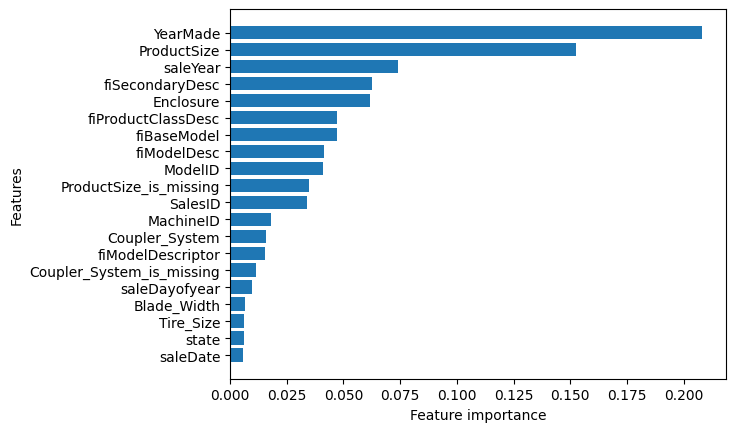

In [153]:
plot_features_oo(X_train.columns, ideal_model.feature_importances_)

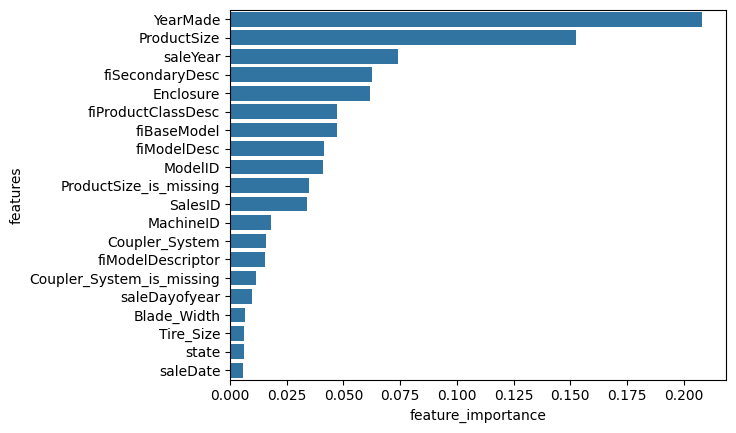

In [154]:
plot_features_seaborn(X_train.columns, ideal_model.feature_importances_)

We will see that YearMade, ProductSize, saleYear are effect to saleprice. SO WE NEED TO COLLECTING MORE DATA OF THIS IN THE FUTURE